# TME 2: IA Explicable

LE LORIER Yann

NGUYEN Hoang-Son 

### 1. Installation

In [1]:
import dice_ml

/Users/yannetu/.local/lib/python3.11/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 2. Données

In [3]:
def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

In [4]:
def halfmoon(n_samples, epsilon):
    pts = np.linspace(0,180, n_samples//2)* np.pi / 180
    haut = np.hstack((np.cos(pts).reshape((-1,1)), np.sin(pts).reshape((-1,1))))
    bas = np.hstack((1-np.cos(pts).reshape((-1,1)), 0.5-np.sin(pts).reshape((-1,1))))
    data = np.vstack((haut,bas))
    data[:,0]+=np.random.normal(0,epsilon,n_samples)
    data[:,1]+=np.random.normal(0,epsilon,n_samples)
    y = np.zeros(n_samples)
    y[n_samples//2:]=1
    return data, y

In [5]:
hm = halfmoon(1000, 0.1)

In [6]:
hm_df = pd.DataFrame(hm[0], columns=['x','y'])
hm_df['target'] = hm[1]

In [7]:
hm_df.columns

Index(['x', 'y', 'target'], dtype='object')

In [8]:
hm_dice = dice_ml.Data(dataframe=hm_df, continuous_features=['x','y'], outcome_name='target')

### 3. Classifieurs

---
#### sklearn

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(hm_df[['x', 'y']], hm_df['target'], test_size=0.2, shuffle = True)

In [12]:
clf = SVC(probability=True)

In [13]:
clf.fit(X_train, y_train)

SVC(probability=True)

In [14]:
model = dice_ml.Model(model=clf, backend="sklearn")

### 4. Exemples contrefactuels

In [15]:
explainer = dice_ml.Dice(hm_dice, model, method='random')
# random, genetic or kdtree

In [16]:
hm_df.head()

,x,y,target
0,1.075597,-0.031142,0.0
1,1.059263,-0.068841,0.0
2,0.796431,0.026331,0.0
3,0.981968,0.158419,0.0
4,0.884737,-0.015016,0.0


In [17]:
query_instances = hm_df.drop(columns="target")[0:1]
counterfactuals = explainer.generate_counterfactuals(
    query_instances=query_instances,
    total_CFs=4,
    desired_class='opposite',
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary='all',
    permitted_range=None,
    posthoc_sparsity_param=0.1
)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


### 5. Visualisation

In [18]:
counterfactuals.visualize_as_dataframe()

Query instance (original outcome : 0)


,x,y,target
0,1.075597,-0.031142,0



Diverse Counterfactual set (new outcome: 1.0)


,x,y,target
0,1.352880,-0.653955,1
1,0.703986,-0.031142,1
2,-0.108875,-0.031142,1
3,0.201167,-0.031142,1


In [19]:
counterfactuals.cf_examples_list[0].final_cfs_df.iloc[0]

x         1.352880
y        -0.653955
target    1.000000
Name: 0, dtype: float64

### 6. Visualisations et expérimentations

In [20]:
from sklearn.inspection import DecisionBoundaryDisplay
def visualisation_2D(data, y, clf, x, cfs) -> None:
    """
    Params:
      data: données
      y   : labels des données
      clf : un classifieur
      x   : un point de départ dont point cicle nous voulons chercher
      cfs : contrefactuels générés
    """
    disp = DecisionBoundaryDisplay.from_estimator(
      clf, data, response_method="predict",
      xlabel="X", ylabel="Y",
      alpha=0.5)
    disp.ax_.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y, edgecolor="k",alpha=0.2)
    disp.ax_.scatter(x.iloc[0][0], x.iloc[0][1], color="red", label="point choisi")
    disp.ax_.scatter(cfs[:, 0], cfs[:, 1], color="green", label="CF générés")
    
    plt.legend()
    plt.show()

In [21]:
cfs = counterfactuals.cf_examples_list[0].final_cfs_df.drop(columns="target")
cfs_np = cfs.to_numpy()

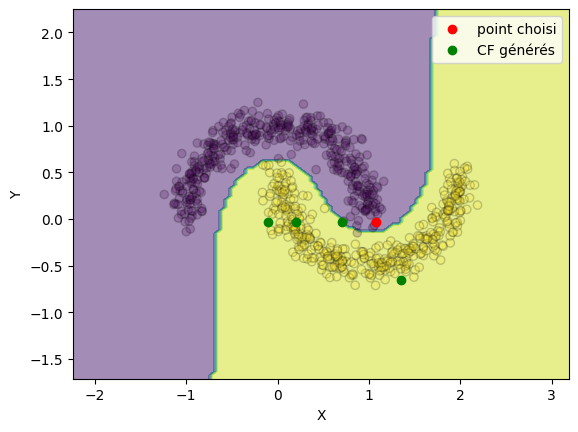

In [22]:
visualisation_2D(X_train, y_train, clf, query_instances, cfs_np)

Puisque nous allons générer des données contrefactuelles plusieurs fois, nous pouvons alors implémenter une fonction pour faire varier les arguments plus facilement: `gen_cfs_and_visualize`.

In [23]:
def gen_cfs(explainer, query_instances, target=None, ftv=None, n_counterfactuals=4):
    """
    Cette fonction prépare les données pour les passer à la fonction de visualisation `visualisation_2D`
    
    explainer: l'instance de Dice pour expliquer.
    query_instances: le X particulier à faire varier
    features_to_vary: les attributs de X à faire varier pour obtenir des contrefactuels différents
    """
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=query_instances,
        total_CFs=n_counterfactuals,
        desired_class='opposite',
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary='all' if ftv is None else ftv,
        permitted_range=None,
        posthoc_sparsity_param=0.1
    )
    cfs = counterfactuals.cf_examples_list[0].final_cfs_df.drop(columns=target)
    cfs_np = cfs.to_numpy()
    
    return cfs, cfs_np

#### 6.1 Variations dans l'appel à la fonction

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


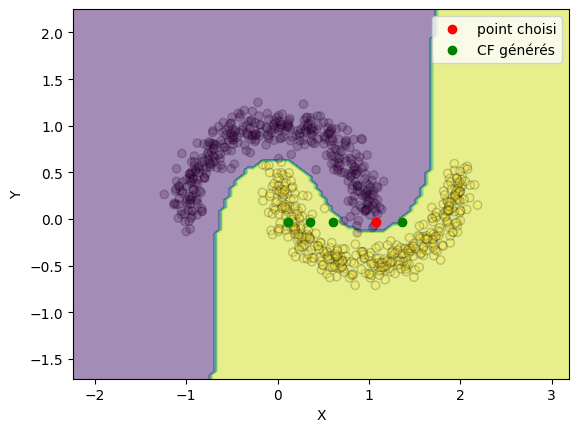

In [24]:
cfs, cfs2_np = gen_cfs(explainer, query_instances, ftv=['x'], target='target')
visualisation_2D(X_train, y_train, clf, query_instances, cfs2_np)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.23it/s]


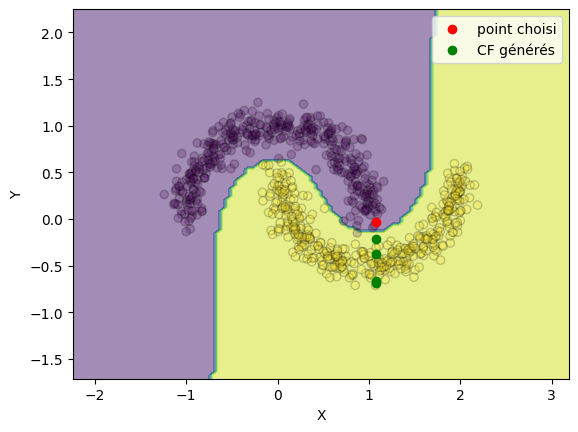

In [25]:
cfs3, cfs3_np = gen_cfs(explainer, query_instances, ftv=['y'], target='target')
visualisation_2D(X_train, y_train, clf, query_instances, cfs3_np)

#### 6.2 Variations dans le point choisi

In [26]:
query_instances = hm_df.drop(columns="target")[300:301]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


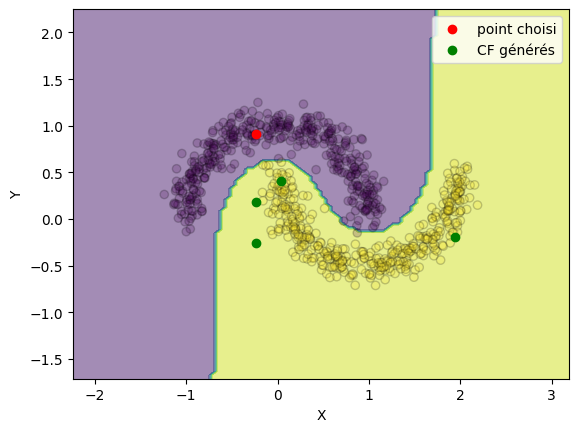

In [27]:
cfs4, cfs4_np = gen_cfs(explainer, query_instances, target='target')
visualisation_2D(X_train, y_train, clf, query_instances, cfs4_np)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 46.90it/s]


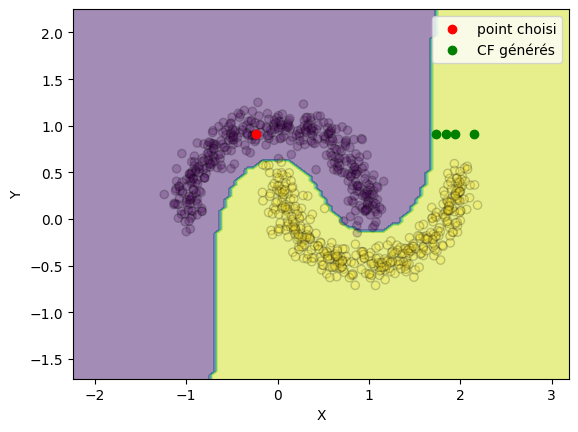

In [28]:
cfs5, cfs5_np = gen_cfs(explainer, query_instances, ftv=['x'], target='target')
visualisation_2D(X_train, y_train, clf, query_instances, cfs5_np)

#### 6.3 Validité des exemples contrefactuels

Nous pouvons voir que dans certains cas, les exemples contrefactuels ne sont pas valides, c'est à dire qu'ils n'appartiennent pas à la classe souhaitée. Nous pouvons alors utiliser un critère d'évaluation pour analyser ces exemples générés.

Nous proposons:

$$
\text{validity}(e, Y_C) = \frac{\sum_{i=1}^{n} [\min{(dist(e_i, Y_C))} < t]}{n}, \quad i \in \{1,\dots,n\}
$$

Où:
- $n$ est le nombre d'exemples contrefactuels
- $Y_C$ est l'ensemble de points qui appartiennent à la classe $C$
- $e_i$ est le i-ème exemple contrefactuel dans l'ensemble $e$
- $t$ est un seuil imposé à ne pas dépasser

Ce calcul permet de savoir quel est la proportion d'exemples contrefactuels qui sont assez proches de notre ensemble de la classe cible.

*Note*: on utilise la [notation Iverson](https://en.wikipedia.org/wiki/Iverson_bracket) pour la description de la formule, donc $[\min{(dist(e_i, Y_C))} < t]$ vaut 1 si la condition est vraie, 0 sinon.

In [29]:
def compute_validity(cf_points, desired_dataset, thresh=0.05):
    points_within_threshold = 0
    for cf_point in cf_points:
        dists = np.linalg.norm(desired_dataset-cf_point, axis=1)
        min_distance_index = np.argmin(dists)
        if dists[min_distance_index] < thresh:
            points_within_threshold += 1
    return points_within_threshold / len(cf_points)

On cherche tous les points qui appartiennent à la classe 1.0. On peut alors les comparer aux points générés par DiCE pour voir s'ils sont acceptables.

In [30]:
# cinquième exemple: cfs5 généré
compute_validity(cfs5_np, hm_df.query("target == 1.0")[['x', 'y']].to_numpy())

0.0

Revenons au premier exemple. Nous pouvons constater que la validité des exemples contrefactuels est meilleure, puisque la proportion d'exemples contrefactuels qui ne dépassent pas le seuil en distance est de 50%.

In [31]:
# Premier exemple: cfs généré
compute_validity(cfs_np, hm_df.query("target == 1.0")[['x', 'y']].to_numpy())

0.25

#### 6.4 Parcimonie des exemples contrefactuels

Nous proposons la suivante méthode d'analyse numérique pour la parcimonie, inspirée de la validité définie dans la section précédente.

$$
\text{parsimony}(x, e) = \sum_{i=1}^{n_x} |x_i - e_i|
$$

In [32]:
def compute_parsimony(x_point, cf_points, feats):
    #TODO not done
    parsimony = 0
    for cf_point in cf_points:
        for feat in feats:
            parsimony += np.abs(x_point[feat] - cf_point[feat])
    return parsimony

#### 6.5 Données classiques

Nous analyserons les données classiques du dataset de vins.

In [33]:
data_wine_path = 'data/winequality-red.csv'
df_wine = pd.read_csv(data_wine_path)

In [34]:
df_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Nous allons observer le comportement d'un classifieur de la qualité des vins. Nous définissons un vin qui est "de qualité" quand son score de "quality" est supérieur ou égal à 7.

In [35]:
df_wine['quality'] = np.where(df_wine['quality'] >= 7, 1, 0)

In [36]:
def prepare_X(df):
    return df.values

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
df_train, df_test = train_test_split(df_wine, test_size=0.2, random_state=1)

y_train = df_train.quality.values
y_test = df_test.quality.values

del df_train['quality']
del df_test['quality']

x_train = prepare_X(df_train)
x_test = prepare_X(df_test)

In [39]:
cols = list(df_wine.columns)
cols.pop() # on enlève quality
cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_wine[cols], df_wine['quality'], test_size=0.2, shuffle = True)
clf_wine = RandomForestClassifier(n_estimators=50, random_state=24)
clf_wine.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=24)

Nous pouvons maintenant créer un nouveau objet df_dice qui contient tous les attributs de la classe sauf celui à prédire: `quality`.

In [41]:
df_dice = dice_ml.Data(dataframe=df_wine, continuous_features=cols, outcome_name='quality')

In [42]:
model = dice_ml.Model(model=clf_wine, backend="sklearn")

In [43]:
explainer = dice_ml.Dice(df_dice, model, method='random')

In [44]:
query_instances = df_wine.drop(columns="quality")[0:1]
df_wine[0:1]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


La donnée `df_wine[0:1]` est un vin qui n'est pas de qualité selon nos critères. Les contrefactuels générés sont alors pour la classe `quality == 1`.

In [45]:
cfs_wine, cfs_wine_np = gen_cfs(explainer, query_instances, target='quality', n_counterfactuals=7)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


In [52]:
compute_validity(cfs_wine_np, df_wine.query("quality == 1")[cols].to_numpy(), thresh=4.7)

0.8571428571428571

### Conclusions

Pour obtenir un résultat similaire aux half moons, il est nécessaire d'augmenter le seuil `thresh` dans l'appel à la fonction `compute_validity`. Il semble que la génération d'exemples contrefactuels qui sont valides dépend aussi de la dimensionalité du problème. Nous pouvons conclure que la méthode DiCE a quelques limitation en termes de la validité des exemples qui sont générés, puisque nous pouvons obtenir des résultats divers en changeant quelques paramètres de dice_ml.